In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from sklearn.preprocessing import LabelEncoder
import joblib
import threading
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor

In [90]:
data = pd.read_csv("./train-metadata.csv", low_memory=False)
data.shape

(401059, 55)

In [91]:
data.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [80]:
def feature_extractor(img,label):
    df = {}

    GSLM = graycomatrix(img, [1], [0])       
    GSLM_Energy = graycoprops(GSLM, 'energy')[0]
    df['0'] = GSLM_Energy[0]
    GSLM_corr = graycoprops(GSLM, 'correlation')[0]
    df['1'] = GSLM_corr[0]       
    GSLM_diss = graycoprops(GSLM, 'dissimilarity')[0]
    df['2'] = GSLM_diss[0]       
    GSLM_hom = graycoprops(GSLM, 'homogeneity')[0]
    df['3'] = GSLM_hom[0]       
    GSLM_contr = graycoprops(GSLM, 'contrast')[0]
    df['4'] = GSLM_contr[0]

    GSLM2 = graycomatrix(img, [3], [0])       
    GSLM_Energy2 = graycoprops(GSLM2, 'energy')[0]
    df['5'] = GSLM_Energy2[0]
    GSLM_corr2 = graycoprops(GSLM2, 'correlation')[0]
    df['6'] = GSLM_corr2[0]       
    GSLM_diss2 = graycoprops(GSLM2, 'dissimilarity')[0]
    df['7'] = GSLM_diss2[0]       
    GSLM_hom2 = graycoprops(GSLM2, 'homogeneity')[0]
    df['8'] = GSLM_hom2[0]       
    GSLM_contr2 = graycoprops(GSLM2, 'contrast')[0]
    df['9'] = GSLM_contr2[0]

    GSLM3 = graycomatrix(img, [5], [0])       
    GSLM_Energy3 = graycoprops(GSLM3, 'energy')[0]
    df['10'] = GSLM_Energy3[0]
    GSLM_corr3 = graycoprops(GSLM3, 'correlation')[0]
    df['11'] = GSLM_corr3[0]       
    GSLM_diss3 = graycoprops(GSLM3, 'dissimilarity')[0]
    df['12'] = GSLM_diss3[0]       
    GSLM_hom3 = graycoprops(GSLM3, 'homogeneity')[0]
    df['13'] = GSLM_hom3[0]       
    GSLM_contr3 = graycoprops(GSLM3, 'contrast')[0]
    df['14'] = GSLM_contr3[0]

    GSLM4 = graycomatrix(img, [0], [np.pi/4])       
    GSLM_Energy4 = graycoprops(GSLM4, 'energy')[0]
    df['15'] = GSLM_Energy4[0]
    
    return df

In [51]:
features = pd.DataFrame(columns=['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])

index = 0

for row in data.values:
    img = cv2.imread("./train-image/image/%s.jpg" %row[0], 0)
    img = cv2.resize(img, (800, 800))
    temp = list(row)
    temp.extend(feature_extractor(img,row[1]).values())
    features.loc[index] = temp
    index += 1
    
    if index % 1000 == 0:
        print("%d, " %index, end="")

KeyboardInterrupt: 

In [1]:
features.to_csv("Processed.csv")

NameError: name 'features' is not defined

In [6]:
features = pd.read_csv("Processed.csv", low_memory=False)

In [176]:
data = features[['target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
       'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
       'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
        'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'mel_mitotic_index', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence', '0', '1', '2', '3', '4', '5', '6', '8',
       '9', '12', '15']]
#tbp_lv_norm_color
#data = features.drop(['Unnamed: 0', 'image_type','tbp_tile_type','attribution','copyright_license','lesion_id','iddx_full','patient_id','isic_id',"iddx_1","iddx_2","iddx_3","iddx_4","iddx_5","mel_thick_mm", "mel_mitotic_index","7","10","11","13","14"],axis = 1)

In [177]:
data.columns

Index(['target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
       'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
       'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'mel_mitotic_index', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence', '0', '1', '2', '3', '4', '5', '6', '8',
       '9', '12', '15'],
      dtype='object')

In [178]:
non_numerical_columns = data.select_dtypes(exclude=['number']).columns

# Convert to a list if needed
non_numerical_columns_list = list(non_numerical_columns)

print(non_numerical_columns_list)

['sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple', 'mel_mitotic_index']


In [179]:
import pickle

data_new = data
data1 = {}
save_file = open("cases.dat", "wb")

for j in non_numerical_columns_list:
    a = list(set(list(data_new[j])))
    index = 0
    dic = {}
    for i in a:
        dic[i] = index
        index += 1

    data1[j] = dic

pickle.dump(data1, save_file)
save_file.close()

In [180]:
data_file = open("cases.dat", "rb")
cases = pickle.load(data_file)
type(cases)
data_file.close()

In [181]:
for i in cases:
    for j in cases[i]:
        data_new[i] = data_new[i].replace(j, cases[i][j])

C:\Users\saiet\AppData\Local\Temp\ipykernel_51604\952098303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new[i] = data_new[i].replace(j, cases[i][j])
C:\Users\saiet\AppData\Local\Temp\ipykernel_51604\952098303.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_new[i] = data_new[i].replace(j, cases[i][j])


In [182]:
data_new

target  age_approx  sex  anatom_site_general  clin_size_long_diam_mm  \
0            0        60.0    2                    4                    3.04   
1            0        60.0    2                    3                    1.10   
2            0        60.0    2                    2                    3.40   
3            0        65.0    2                    0                    3.22   
4            0        55.0    2                    0                    2.73   
...        ...         ...  ...                  ...                     ...   
401054       0        70.0    2                    0                    6.80   
401055       0        60.0    2                    2                    3.11   
401056       0        65.0    0                    0                    2.05   
401057       0        30.0    0                    0                    2.80   
401058       0        50.0    2                    4                    3.30   

         tbp_lv_A  tbp_lv_Aext   tbp_lv_B  tbp_lv_Bext   tbp_lv_C  ...  \
0       20.244422    16.261975  26.922447    23.954773  33.684638  ...   
1       31.712570    25.364740  26.331000    24.549290  41.219030  ...   
2       22.575830    17.128170  37.970460    33.485410  44.174920  ...   
3       14.242329    12.164757  21.448144    21.121356  25.746200  ...   
4       24.725520    20.057470  26.464900    25.710460  36.217980  ...   
...           ...          ...        ...          ...        ...  ...   
401054  22.574335    14.944666  27.663259    26.767135  35.705132  ...   
401055  19.977640    16.026870  34.158840    31.011870  39.571870  ...   
401056  17.332567    12.364397  29.845326    26.500073  34.513206  ...   
401057  22.288570     9.564721  28.431200    27.012250  36.126360  ...   
401058  16.792900    11.434730  21.457220    21.214910  27.247270  ...   

               1         2         3         4         5         6         8  \
0       0.995407  0.570045  0.729752  0.718109  0.069896  0.969674  0.439391   
1       0.995414  0.883381  0.621010  1.537013  0.049560  0.965190  0.331694   
2       0.997565  0.492819  0.761879  0.575757  0.065654  0.984896  0.479583   
3       0.998503  0.346510  0.828859  0.367652  0.075459  0.992252  0.584999   
4       0.997093  0.513888  0.752340  0.607207  0.064986  0.981493  0.463134   
...          ...       ...       ...       ...       ...       ...       ...   
401054  0.999450  0.499443  0.762344  0.620604  0.072442  0.996506  0.488419   
401055  0.997146  0.488614  0.764851  0.580682  0.074116  0.982444  0.486601   
401056  0.997717  0.315893  0.843501  0.330371  0.095693  0.988815  0.608884   
401057  0.998493  0.327015  0.839117  0.353395  0.092291  0.992245  0.610181   
401058  0.999062  0.556022  0.737841  0.715587  0.047568  0.993687  0.454362   

                9        12        15  
0        4.740494  2.641945  0.184858  
1       11.668860  4.125442  0.155813  
2        3.570464  2.288767  0.163991  
3        1.903342  1.614436  0.159799  
4        3.862825  2.415203  0.166973  
...           ...       ...       ...  
401054   3.951402  2.311936  0.172276  
401055   3.574448  2.250429  0.180330  
401056   1.619813  1.482426  0.193177  
401057   1.820486  1.506836  0.185053  
401058   4.817006  2.621909  0.123704  

[401059 rows x 52 columns]

In [183]:
data.columns

Index(['target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
       'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
       'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'mel_mitotic_index', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence', '0', '1', '2', '3', '4', '5', '6', '8',
       '9', '12', '15'],
      dtype='object')

In [184]:
df_target_1 = data[data['target'] == 1]
df_target_0 = data[data['target'] == 0]

#figure out how to fix thiss part.... compare with counter part in threaded
#x1train, x1test, y1train, y1test = train_test_split(df_target_1.drop("target", axis=1), df_target_1["target"], test_size=0.1)
x1trainset,x1testset = train_test_split(df_target_1, test_size=0.1, stratify=df_target_1['target'], random_state=42)
#x0train, x0test, y0train, y0test = train_test_split(df_target_0.drop("target", axis=1), df_target_0["target"], test_size=0.1)\
x0trainset,x0testset = train_test_split(df_target_0, test_size=0.1, stratify=df_target_0['target'], random_state=42)
#batchof1 = pd.concat([x1trainset, x1train], ignore_index=True, axis=1)
#batchof0 = pd.concat([x0train, y0train], ignore_index=True, axis=1)
x0trainset

target  age_approx  sex  anatom_site_general  clin_size_long_diam_mm  \
8451         0        65.0    2                    4                    5.84   
99228        0        65.0    2                    2                    4.48   
33199        0        45.0    0                    5                    4.25   
362170       0        75.0    2                    0                    8.67   
85335        0        45.0    2                    5                    2.62   
...        ...         ...  ...                  ...                     ...   
292034       0        70.0    2                    2                    4.29   
110459       0        80.0    2                    4                    5.32   
101751       0        45.0    2                    5                    3.21   
257852       0        45.0    0                    0                    3.97   
124740       0        80.0    2                    5                    5.11   

         tbp_lv_A  tbp_lv_Aext   tbp_lv_B  tbp_lv_Bext   tbp_lv_C  ...  \
8451    17.540580    17.465360  19.988560    24.622100  26.593500  ...   
99228   23.016716    17.884865  40.043682    39.008299  46.187289  ...   
33199   20.573576    16.972951  31.232260    29.753295  37.399547  ...   
362170  19.884140    11.659230  21.184780    18.943610  29.054670  ...   
85335   23.600010    19.611470  28.442040    27.230170  36.958220  ...   
...           ...          ...        ...          ...        ...  ...   
292034  28.381057    24.440091  26.538814    26.126880  38.856055  ...   
110459  16.699813    12.529559  23.772972    22.789801  29.052331  ...   
101751  19.307753     9.944091  31.817753    26.962266  37.217721  ...   
257852  20.270980    12.564840  27.718850    26.584470  34.340170  ...   
124740  20.158977    14.230609  32.562986    27.796118  38.297943  ...   

               1         2         3         4         5         6         8  \
8451    0.997010  0.729445  0.669421  1.076153  0.052743  0.978662  0.375192   
99228   0.998210  0.537491  0.747061  0.706417  0.069873  0.988144  0.463025   
33199   0.997288  0.377317  0.814709  0.410990  0.085169  0.985500  0.565902   
362170  0.998439  0.433378  0.789129  0.491613  0.083882  0.990886  0.521705   
85335   0.997205  0.564754  0.730499  0.694035  0.059819  0.981528  0.435519   
...          ...       ...       ...       ...       ...       ...       ...   
292034  0.997891  0.478666  0.768257  0.554789  0.063812  0.986898  0.485030   
110459  0.997719  0.454323  0.779782  0.523894  0.068470  0.986353  0.507131   
101751  0.998201  0.416120  0.798349  0.480839  0.101429  0.989615  0.543397   
257852  0.999067  0.272897  0.865250  0.289947  0.091291  0.995559  0.662325   
124740  0.997079  0.422858  0.793597  0.473262  0.083413  0.983112  0.524327   

               9        12        15  
8451    7.689575  3.360552  0.157388  
99228   4.685518  2.507577  0.175269  
33199   2.198101  1.709190  0.185663  
362170  2.872401  2.003215  0.189679  
85335   4.588681  2.650978  0.160850  
...          ...       ...       ...  
292034  3.445136  2.267662  0.158189  
110459  3.136874  2.103289  0.162949  
101751  2.781145  1.892654  0.224244  
257852  1.383817  1.260668  0.167992  
124740  2.737530  1.979351  0.192575  

[360599 rows x 52 columns]

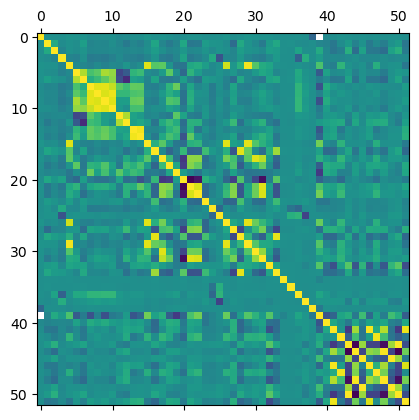

In [185]:
correlation_matrix = data.corr()
import matplotlib.pyplot as plt
plt.matshow(correlation_matrix, cmap='viridis')
plt.show()


In [186]:
correlated_pairs = []
threshold = 0.95
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if ((correlation_matrix.iloc[i, j]) > threshold):
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            correlated_pairs.append((colname1, colname2, correlation_matrix.iloc[i, j]))

# Print the correlated pairs
print("Pairs of columns with correlation above threshold:")
print(len(correlated_pairs))
for pair in correlated_pairs:
    print(f"Columns: {pair[0]} and {pair[1]} with correlation: {pair[2]:.2f}")

Pairs of columns with correlation above threshold:
7
Columns: tbp_lv_Lext and tbp_lv_L with correlation: 0.96
Columns: tbp_lv_perimeterMM and clin_size_long_diam_mm with correlation: 0.97
Columns: 5 and 0 with correlation: 0.97
Columns: 6 and 1 with correlation: 0.96
Columns: 8 and 3 with correlation: 0.98
Columns: 9 and 4 with correlation: 1.00
Columns: 12 and 2 with correlation: 1.00


In [187]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [188]:
tprsacc = []
final_predict_data = data.drop(["target"],axis=1)

def trainer(number,batch):
    #print(pd.DataFrame(batch))
    #print(number)
    scaler = StandardScaler()

    trainn_set, testn_set = train_test_split(batch, test_size=0.2, stratify=batch['target'], random_state=42)
    X_trainn = trainn_set.drop(columns=['target'])
    y_trainn = trainn_set['target']
    X_testn= testn_set.drop(columns=['target'])
    y_testn = testn_set['target']
    X_trainn = scaler.fit_transform(X_trainn)
    X_testn = scaler.transform(X_testn)
    
    model = lgb.LGBMClassifier(verbose=-1)
    model.fit(X_trainn, y_trainn)
    print("model"+str(number))
    name = "model" + str(number) + ".joblib"
    
    predictions = model.predict(X_testn)
    tn, fp, fn, tp = confusion_matrix(y_testn, predictions).ravel()
    accuracy = accuracy_score(y_testn,predictions)
    tprsacc.append((tp/(tp+fn),accuracy))

    joblib.dump(model, name)
    
    #predictions = model.predict(X_testn)
    #tn, fp, fn, tp = confusion_matrix(y_testn, predictions).ravel()
    
    #accuracy = accuracy_score(y_testn,predictions)
    #print("model number"+str(i)+" true positives: "+str(tp/(tp+fn)))
    #print("model number"+str(i)+" accuracu: "+str(accuracy))
    
    
    # Make predictions and evaluate
    


In [189]:
x1trainset

target  age_approx  sex  anatom_site_general  clin_size_long_diam_mm  \
30139        1        55.0    1                    5                    1.64   
265953       1        60.0    2                    3                    5.54   
63455        1        60.0    2                    3                    2.05   
194003       1        45.0    2                    4                    6.57   
217873       1        60.0    2                    0                    5.44   
...        ...         ...  ...                  ...                     ...   
396165       1        50.0    0                    2                    8.16   
128872       1        60.0    2                    5                    3.01   
25548        1        55.0    2                    4                    1.37   
24133        1        70.0    2                    2                   16.57   
224515       1        85.0    2                    3                    1.37   

         tbp_lv_A  tbp_lv_Aext   tbp_lv_B  tbp_lv_Bext   tbp_lv_C  ...  \
30139   27.716638    20.774094  36.111406    31.033226  45.521926  ...   
265953  23.012934    20.416961  28.014512    23.952397  36.254766  ...   
63455   35.801100    35.559420  27.269780    26.995520  45.004000  ...   
194003  28.278120    21.899220  28.698530    33.666870  40.289670  ...   
217873  29.360032    21.997614  28.355034    27.784677  40.816901  ...   
...           ...          ...        ...          ...        ...  ...   
396165  17.351658    11.348823  23.910937    24.652597  29.543408  ...   
128872  17.243580    10.074100  27.808540    27.686740  32.720880  ...   
25548   18.526850    14.341830  11.467240    12.637140  21.788570  ...   
24133   14.520877    22.801820  14.008138    23.726100  20.176318  ...   
224515  24.020452    19.941758  22.891751    23.834365  33.181536  ...   

               1         2         3         4         5         6         8  \
30139   0.997095  0.356386  0.825022  0.388558  0.094302  0.984636  0.581846   
265953  0.998748  0.472791  0.773287  0.570210  0.061185  0.992173  0.501448   
63455   0.999780  0.319687  0.849595  0.427103  0.053464  0.998652  0.643958   
194003  0.998190  0.532459  0.751006  0.717290  0.057320  0.987987  0.471839   
217873  0.998089  0.563306  0.741009  0.805530  0.055515  0.986883  0.460577   
...          ...       ...       ...       ...       ...       ...       ...   
396165  0.998625  0.407373  0.803686  0.481804  0.082357  0.992017  0.553863   
128872  0.999175  0.376245  0.817374  0.432575  0.088528  0.995364  0.571968   
25548   0.995259  0.205416  0.897633  0.208824  0.158208  0.980670  0.728093   
24133   0.999246  0.677993  0.689134  0.963847  0.036703  0.994616  0.393163   
224515  0.997619  0.616873  0.710073  0.802708  0.058560  0.983722  0.410346   

               9        12        15  
30139   2.057177  1.641901  0.197990  
265953  3.566120  2.212932  0.146728  
63455   2.615386  1.523786  0.098072  
194003  4.762776  2.475193  0.144669  
217873  5.531375  2.646564  0.144384  
...          ...       ...       ...  
396165  2.800703  1.848447  0.177576  
128872  2.431832  1.732385  0.185812  
25548   0.851982  0.963989  0.259503  
24133   6.879446  3.197382  0.106203  
224515  5.492511  2.896901  0.161168  

[353 rows x 52 columns]

In [190]:
x0trainset[:353]

target  age_approx  sex  anatom_site_general  clin_size_long_diam_mm  \
8451         0        65.0    2                    4                    5.84   
99228        0        65.0    2                    2                    4.48   
33199        0        45.0    0                    5                    4.25   
362170       0        75.0    2                    0                    8.67   
85335        0        45.0    2                    5                    2.62   
...        ...         ...  ...                  ...                     ...   
296179       0        30.0    0                    4                    6.24   
81076        0        65.0    2                    0                    3.76   
310469       0        35.0    2                    0                    3.61   
276631       0        85.0    2                    4                    6.99   
249810       0        75.0    2                    2                    2.50   

         tbp_lv_A  tbp_lv_Aext   tbp_lv_B  tbp_lv_Bext   tbp_lv_C  ...  \
8451    17.540580    17.465360  19.988560    24.622100  26.593500  ...   
99228   23.016716    17.884865  40.043682    39.008299  46.187289  ...   
33199   20.573576    16.972951  31.232260    29.753295  37.399547  ...   
362170  19.884140    11.659230  21.184780    18.943610  29.054670  ...   
85335   23.600010    19.611470  28.442040    27.230170  36.958220  ...   
...           ...          ...        ...          ...        ...  ...   
296179  18.316668    15.481069  22.691507    24.660778  29.161701  ...   
81076   19.550893    13.491389  29.375784    26.096930  35.287025  ...   
310469  22.038006    16.133542  26.199930    24.361994  34.236093  ...   
276631  13.157395     9.804300  20.550312    20.726881  24.401484  ...   
249810  17.171212    12.622038  33.381271    31.194459  37.538777  ...   

               1         2         3         4         5         6         8  \
8451    0.997010  0.729445  0.669421  1.076153  0.052743  0.978662  0.375192   
99228   0.998210  0.537491  0.747061  0.706417  0.069873  0.988144  0.463025   
33199   0.997288  0.377317  0.814709  0.410990  0.085169  0.985500  0.565902   
362170  0.998439  0.433378  0.789129  0.491613  0.083882  0.990886  0.521705   
85335   0.997205  0.564754  0.730499  0.694035  0.059819  0.981528  0.435519   
...          ...       ...       ...       ...       ...       ...       ...   
296179  0.998630  0.473853  0.771750  0.560715  0.087855  0.991668  0.501821   
81076   0.995984  0.498673  0.759553  0.587578  0.081056  0.974797  0.477503   
310469  0.998081  0.454659  0.781126  0.539509  0.082782  0.988453  0.513886   
276631  0.995878  0.842315  0.635958  1.445729  0.048909  0.968979  0.344808   
249810  0.999128  0.557093  0.739045  0.738026  0.052473  0.994082  0.456346   

                9        12        15  
8451     7.689575  3.360552  0.157388  
99228    4.685518  2.507577  0.175269  
33199    2.198101  1.709190  0.185663  
362170   2.872401  2.003215  0.189679  
85335    4.588681  2.650978  0.160850  
...           ...       ...       ...  
296179   3.416062  2.161910  0.203148  
81076    3.682864  2.317668  0.199070  
310469   3.251245  2.088140  0.192261  
276631  10.884843  3.927803  0.153549  
249810   5.012597  2.631428  0.132078  

[353 rows x 52 columns]

In [206]:
threads = []
import time

start_time = time.time()


for i in range(0,1018):
    batch = batch1 = pd.concat([x1trainset,x0trainset[i*353:(i*353)+353]], ignore_index=True)
       
    thread = threading.Thread(target=trainer, args=(i,batch))
    threads.append(thread)
    thread.start()
end_time = time.time()
total_time = end_time - start_time
total_time
#batch
tprsacc

model0
model2
model3
model4
model6
model1model5

model8
model9
model10
model14
model13
model12
model11
model17
model18
model7
model15
model19
model20
model21
model26
model23
model24
model27
model25
model16
model30
model29
model35
model28
model34
model36
model37
model38
model42
model39
model41
model45
model32
model31
model22
model46
model50
model58
model53
model40
model57
model59
model44
model67
model47
model43
model62
model63
model77
model69
model65
model68
model79


[(0.7887323943661971, 0.852112676056338),
 (0.8169014084507042, 0.8450704225352113),
 (0.8591549295774648, 0.8450704225352113),
 (0.7887323943661971, 0.8309859154929577),
 (0.8169014084507042, 0.8591549295774648),
 (0.8028169014084507, 0.8450704225352113),
 (0.8169014084507042, 0.8309859154929577),
 (0.7887323943661971, 0.852112676056338),
 (0.8450704225352113, 0.8802816901408451),
 (0.8169014084507042, 0.852112676056338),
 (0.8450704225352113, 0.8661971830985915),
 (0.8309859154929577, 0.8943661971830986),
 (0.8309859154929577, 0.8943661971830986),
 (0.8309859154929577, 0.8309859154929577),
 (0.8309859154929577, 0.8380281690140845),
 (0.8169014084507042, 0.823943661971831),
 (0.8169014084507042, 0.8591549295774648),
 (0.8169014084507042, 0.823943661971831),
 (0.8450704225352113, 0.8943661971830986),
 (0.8028169014084507, 0.8591549295774648),
 (0.8450704225352113, 0.8802816901408451),
 (0.8028169014084507, 0.8450704225352113),
 (0.8309859154929577, 0.823943661971831),
 (0.8873239436619

model33
model49
model71
model70
model48
model89
model54
model82
model86
model108
model94
model98
model55
model52
model114
model120
model72
model60
model51
model64
model113
model132
model76
model73
model66
model56
model141
model90
model74
model96
model75
model80
model83
model104
model107
model87
model161
model81
model111
model169
model85
model100
model164
model91
model172
model110
model173
model88
model78
model84
model116
model101
model105
model115
model103
model99
model197
model109
model92
model97
model117
model198
model119
model205
model93
model135
model126
model136
model196
model225
model95
model189
model122
model106
model118
model185
model143
model128
model130
model144
model138
model139
model246
model61
model129
model124
model123
model127
model134
model149
model218
model133
model142
model166
model148
model210
model178
model112
model153
model131
model259
model204
model125
model182
model177
model156
model154
model137
model292
model175
model102
model140
model151
model162
model271
model

In [207]:
tprsacc

[(0.7887323943661971, 0.852112676056338),
 (0.8169014084507042, 0.8450704225352113),
 (0.8591549295774648, 0.8450704225352113),
 (0.7887323943661971, 0.8309859154929577),
 (0.8169014084507042, 0.8591549295774648),
 (0.8028169014084507, 0.8450704225352113),
 (0.8169014084507042, 0.8309859154929577),
 (0.7887323943661971, 0.852112676056338),
 (0.8450704225352113, 0.8802816901408451),
 (0.8169014084507042, 0.852112676056338),
 (0.8450704225352113, 0.8661971830985915),
 (0.8309859154929577, 0.8943661971830986),
 (0.8309859154929577, 0.8943661971830986),
 (0.8309859154929577, 0.8309859154929577),
 (0.8309859154929577, 0.8380281690140845),
 (0.8169014084507042, 0.823943661971831),
 (0.8169014084507042, 0.8591549295774648),
 (0.8169014084507042, 0.823943661971831),
 (0.8450704225352113, 0.8943661971830986),
 (0.8028169014084507, 0.8591549295774648),
 (0.8450704225352113, 0.8802816901408451),
 (0.8028169014084507, 0.8450704225352113),
 (0.8309859154929577, 0.823943661971831),
 (0.8873239436619

In [208]:
sorted_based_on_tp = max(tprsacc , key=lambda x: x[0])
sorted_based_on_tp

(0.8873239436619719, 0.8661971830985915)

In [209]:
testing_predictions = {}
#testing_predictions_lock = threading.Lock()

def tester(data, model_number):
    model_name = f"model{model_number}.joblib"
    scaler = StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(data))
    for i in range(len(data)):
        # Prepare the test data
        test_datan = data.iloc[[i]]
        
        # Load the model
        #model_name = f"model{model_number}.joblib"
        model = joblib.load(model_name)
        
        # Predict using the model
        prediction = model.predict(test_datan)
        
        # Initialize the list for key `i` if it does not exist
        if i not in testing_predictions:
            testing_predictions[i] = []
        
        # Append the prediction to the list
        testing_predictions[i].append(prediction[0])

In [210]:
testing_predictions

{}

In [211]:
models = []

for name, accuracy in tprsacc.items():
    if len(models) < 10:
        models.append(name)
        continue
    
    min = tprsacc[models[0]]
    index = 0
    for i in range(1, len(models)):
        length = len(models)
        if tprsacc[models[i]] < min :
            min = tprsacc[models[i]]
            index = i

    if accuracy > min:
        models.pop(index)
        models.append(name)

models

AttributeError: 'list' object has no attribute 'items'

In [212]:
#[tprsacc[models[i]] for i in range(0, 10)]
tprsacc.values()

AttributeError: 'list' object has no attribute 'values'

In [214]:
x1test = x1testset.drop(columns=['target'])
x0test = x0testset.drop(columns=['target'])
y1testset = x1testset['target']
y0testset = x0testset['target']

xInput = pd.concat([x1test,x0test],ignore_index=True).head(400)
yOutput = pd.concat([y1testset,y0testset],ignore_index=True).head(400)
xInput
scaler = StandardScaler()
xInput = pd.DataFrame(scaler.fit_transform(xInput))
for i  in range(0,1018):
    tester(xInput, i)



In [215]:
xInput

0         1         2         3         4         5         6   \
0   -0.549146  0.642188 -0.371780  3.089896  0.305276  0.945437  0.298594   
1    0.124767  0.642188 -0.371780  0.602949  0.859805  0.854385  0.236925   
2    0.798681  0.642188 -0.371780  1.394250  2.292429  2.554992  0.110260   
3    0.124767  0.642188  0.202398  2.034827 -0.440104 -0.604383 -1.046287   
4   -1.223060 -1.601263  0.776575  1.348195  1.339732 -0.237006 -1.406189   
..        ...       ...       ...       ...       ...       ...       ...   
395  1.135638  0.642188 -1.520136 -0.669832  1.875142 -1.212723 -0.983716   
396 -1.223060  0.642188 -0.371780  0.129843 -0.649159 -0.591470 -0.399120   
397  0.124767 -1.601263  0.776575 -0.556789 -0.534403 -0.086521 -1.489742   
398  0.461724 -1.601263  0.776575 -0.732634  0.984394  0.977074  1.618554   
399 -0.886103  0.642188  1.350753 -0.477241 -0.839184 -0.604694 -0.865980   

           7         8         9   ...        41        42        43  \
0    0.803618  0.322299  0.971972  ...  0.602207  0.671594 -0.842813   
1    0.762206  0.538063  0.902473  ... -0.079036 -0.500244  0.475165   
2    0.831815  1.208072  1.727905  ...  0.645066  0.392980 -0.508956   
3   -1.312705 -1.012701 -1.308014  ...  0.830488  0.193915 -0.296368   
4   -1.003732 -0.254660 -0.916789  ...  0.998890 -0.318890  0.278659   
..        ...       ...       ...  ...       ...       ...       ...   
395 -0.818620  0.308556 -1.130429  ...  0.790610 -0.355515  0.375342   
396 -0.565528 -0.626957 -0.710015  ...  0.341693 -0.193987  0.120601   
397 -1.097550 -1.370659 -0.923932  ... -0.772402 -0.871293  0.925415   
398  1.526698  1.623236  1.552617  ... -0.825691 -0.390721  0.337192   
399 -0.299994 -1.065857 -0.499423  ... -0.469053 -0.880311  0.949894   

           44        45        46        47        48        49        50  
0    0.257268 -0.913293  0.423715 -0.974777  0.263247  0.707551 -1.092721  
1   -0.470677 -0.007141  0.095919  0.340800 -0.478650 -0.492284  0.026975  
2    0.118724 -0.789149  0.496748 -0.650529  0.114065  0.410375 -1.033548  
3   -0.027167 -0.858093  0.687186 -0.416669 -0.018714  0.252688 -1.236730  
4   -0.347327 -0.131665  0.916686  0.175997 -0.350576 -0.301119 -0.206226  
..        ...       ...       ...       ...       ...       ...       ...  
395 -0.273714 -0.305715  0.720806  0.307269 -0.280639 -0.367603 -0.590500  
396 -0.295272 -0.396277  0.383923 -0.014902 -0.330493 -0.255295 -0.518654  
397 -0.655105  0.718391 -0.231540  0.883549 -0.656334 -0.861177  0.977182  
398 -0.423728  0.393852 -0.518006  0.183010 -0.441415 -0.409267  0.852804  
399 -0.640800  0.688107 -0.024290  0.999057 -0.645801 -0.921827  0.796353  

[400 rows x 51 columns]

In [216]:
yOutput

0      1
1      1
2      1
3      1
4      1
      ..
395    0
396    0
397    0
398    0
399    0
Name: target, Length: 400, dtype: int64

In [217]:
dict = testing_predictions
dict

{0: [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

In [218]:
for key, value in testing_predictions.items():
    # Check if the value is a list of lists, a list, or a single value
    if isinstance(value, list):
        # If it's a list of lists, flatten it
        if all(isinstance(sublist, list) for sublist in value):
            flat_predictions = [item for sublist in value for item in sublist]
        else:
            # If it's a simple list, use it directly
            flat_predictions = value
    else:
        # If it's a single value, convert it to a list
        flat_predictions = [value]
    
    # Convert to pandas Series
    prediction_series = pd.Series(flat_predictions)
    
    # Find the mode (most frequent value)
    mode_value = prediction_series.mode().iloc[0]
    
    # Replace the list with the mode value
    testing_predictions[key] = mode_value


In [219]:
from itertools import chain
testing_predictions_list = list(chain.from_iterable(
    [value] if isinstance(value, (int, float, np.integer, np.floating)) else value 
    for value in testing_predictions.values()
))
testing_predictions_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,


In [220]:
len(testing_predictions_list)

400

In [221]:
tn, fp, fn, tp = confusion_matrix(yOutput, testing_predictions_list).ravel()
print(tp/(tp+fn))
accuracy = accuracy_score(yOutput,testing_predictions_list)
print(tp, tn , fp , fn)
print(accuracy)

0.975
39 233 127 1
0.68
